In [ ]:
# installing packages
import os
os.system('pip install --upgrade pip datasets torch')

In [39]:
# importing dependencies
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [44]:
from sklearn.model_selection import train_test_split
import datasets
from datasets import Dataset

data = pd.read_csv("/work/exam/ASD_classification/CHI_data_short.csv")

In [45]:
# For the logreg and nn
class createDatasetDict:

    # Split dataset into train, test, val (70, 15, 15)
    train, test = train_test_split(data, test_size=0.15)
    train, val = train_test_split(train, test_size=0.15)

    # Turning the split dataframes into dicts
    train = Dataset.from_dict(train)
    val = Dataset.from_dict(val)
    test = Dataset.from_dict(test)

    corpus_dict = datasets.DatasetDict({
        "train":train, 
        "val":val, 
        "test":test
        })

In [46]:
dd = createDatasetDict()
dd = dd.corpus_dict
dd

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 5144
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 908
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1068
    })
})

In [47]:
def bow(X_train, y_train, X_val, y_val, X_test, y_test):
    """ creates the bag of words representation of the train, test
    and validation sets using sklearn's CountVectorizer
    Args:
        X_train: training inputs
        y_train: training targets
        X_val: validation inputs
        y_val: validation targets
        X_test: test inputs
        y_test: test targets
    """
    # load bow from sklearn
    vectorizer = CountVectorizer()

    # fit vocabulary and transform data
    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)

    # transform to tensors
    X_train = torch.tensor(X_train.toarray(), dtype=torch.float)
    y_train = torch.tensor(list(y_train), dtype=torch.float)
    y_train = y_train.view(y_train.shape[0], 1)

    X_val = torch.tensor(X_val.toarray(), dtype=torch.float)
    y_val = torch.tensor(list(y_val), dtype=torch.float)
    y_val = y_val.view(y_val.shape[0], 1)

    X_test = torch.tensor(X_test.toarray(), dtype=torch.float)
    y_test = torch.tensor(list(y_test), dtype=torch.float)
    y_test = y_test.view(y_test.shape[0], 1)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [48]:
def data_loader():
    """ loads the rotten tomatoes dataset and returns
    the training, validation and test splits for inputs X and targets y
    """
    # load the rotten tomatoes dataset
    dataset = dd

    # obtain train, val and test splits
    train = dataset["train"]
    val = dataset["val"]
    test = dataset["test"]

    # splitting into inputs X and targets y
    X_train = train["text"]
    y_train = train["label"]
    X_val = val["text"]
    y_val = val["label"]
    X_test = test["text"]
    y_test = test["label"]

    # applying bow
    X_train, y_train, X_val, y_val, X_test, y_test = bow(X_train, y_train, X_val, y_val, X_test, y_test)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [49]:
class NeuralNetwork(nn.Module):
    """ class initializing a fully-connected neural network
    with one input layer, one hidden layer with 30 nodes
    and one output layers with one node
    """
    def __init__(self, n_input_features=10):
        super().__init__()
        self.linear1 = nn.Linear(n_input_features, 30)
        self.linear2 = nn.Linear(30, 30)
        self.linear3 = nn.Linear(30, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        y_pred = torch.sigmoid(x)
        return y_pred

In [50]:
class LogisticRegression(nn.Module):
    """ class initializing a simple logistic regression classifier
    """
    def __init__(self, n_input_features):
         super().__init__()
         self.linear = torch.nn.Linear(n_input_features, 1)  

    def forward(self, x):
        x = self.linear(x)
        y_pred = torch.sigmoid(x)
        return y_pred

In [55]:
def saveModel(model): 
    """ function to save model after training
    Args:
        model (Module): pytorch model to be saved
    """
    path = os.path.join("/work", "exam", "ASD_classification", "out", "NetModel_" + classifier + ".pth")
    torch.save(model.state_dict(), path)


In [59]:
def train(epochs, classifier = 'nn', plot = True):
    """ function that trains the selected model over
    a specified number of epochs
    Args:
        epochs (int): number of epochs used for training
        classifier (str): the selected classifier
    """
    n_samples, n_features = X_train.shape

    # initializing the chosen classifier
    if classifier == 'nn':
        model = NeuralNetwork(n_input_features=n_features)
    
    elif classifier == 'lr':
        model = LogisticRegression(n_input_features=n_features)

    else:
        print('Not valid classifier - please try again')
        exit()

    # define loss and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters())
    
    best_accuracy = 0.0
    print("[INFO:] Training classifier...")

    train_loss_history = []
    val_loss_history = []
    running_accuracy = 0.0 
    running_val_loss = 0.0 
    total = 0 

    for epoch in range(epochs):
        # forward
        y_train_hat = model(X_train)

        # backward
        train_loss = criterion(y_train_hat, y_train)
        train_loss_history.append(train_loss)

        # backpropagation
        train_loss.backward()

        # take step, reset
        optimizer.step()
        optimizer.zero_grad()

        # some print to see that it is running
        if (epoch + 1) % 10 == 0:
            print(f"epoch: {epoch+1}, train_loss = {train_loss.item():.4f}")
            
        # validation Loop 
        with torch.no_grad(): 
            model.eval() 
            y_val_hat = model(X_val) 
            val_loss = criterion(y_val_hat, y_val) 
            val_loss_history.append(val_loss)
                
            # the label with the highest value will be our prediction 
            _, predicted = torch.max(y_val_hat, 1) 
            running_val_loss += val_loss.item()  
            total += y_val.size(0) 
            running_accuracy += (predicted == y_val).sum().item()
    
        # calculate validation loss value 
        val_loss_value = running_val_loss/len(y_val) 
                    
        # calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
    
        # save the model if the accuracy is the best 
        if accuracy > best_accuracy: 
            saveModel(model) 
            best_accuracy = accuracy 

    if plot:
        # plotting training and validation loss
        loss_train = [val.item() for val in train_loss_history]
        val_train = [val.item() for val in val_loss_history]
        fig, ax = plt.subplots()
        ax.plot(loss_train, label = 'train')
        ax.set_title('Loss history')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.plot(val_train, label = 'val')
        ax.legend()
        plt.savefig(os.path.join("/work", "exam", "ASD_classification", "out", "loss_curve_" + classifier + ".png"))

    print("[INFO:] Finished training!")

In [64]:
def test(n_features, classifier):
    """ Function to evaluate model on test set
    Args:
        n_features (int): number of features
        classifier (str): the selected classifier
    """
    # testing on the best model
    if classifier == 'nn':
        model = NeuralNetwork(n_input_features=n_features)
    else:
        model = LogisticRegression(n_input_features=n_features)
    path = os.path.join("/work", "exam", "ASD_classification", "out", "NetModel_"+ classifier + ".pth")
    model.load_state_dict(torch.load(path)) 
    predicted = model(X_test).detach().numpy()

    # printing and saving classification report
    out = classification_report(y_test, 
                        np.where(predicted > 0.5, 1, 0),
                        target_names = ["Negative", "Positive"]) #xxx change to ASD/TD
    print(out) 
    with open(os.path.join("/work", "exam", "ASD_classification", "out", "classification_report_" + classifier + ".txt"), 'w') as f:
        f.write(out)


 Your chosen classifier nn will be fitted shortly
[INFO:] Training classifier...
epoch: 10, train_loss = 0.7000
epoch: 20, train_loss = 0.6864
epoch: 30, train_loss = 0.6836
epoch: 40, train_loss = 0.6834
epoch: 50, train_loss = 0.6825
epoch: 60, train_loss = 0.6816
epoch: 70, train_loss = 0.6808
epoch: 80, train_loss = 0.6798
epoch: 90, train_loss = 0.6785
epoch: 100, train_loss = 0.6770
epoch: 110, train_loss = 0.6752
epoch: 120, train_loss = 0.6729
epoch: 130, train_loss = 0.6701
epoch: 140, train_loss = 0.6667
epoch: 150, train_loss = 0.6625
epoch: 160, train_loss = 0.6574
epoch: 170, train_loss = 0.6511
epoch: 180, train_loss = 0.6435
epoch: 190, train_loss = 0.6344
epoch: 200, train_loss = 0.6238
[INFO:] Finished training!
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       628
    Positive       0.41      1.00      0.58       440

    accuracy                           0.41      1068
   macro avg       0.21      0.50      0.2

/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


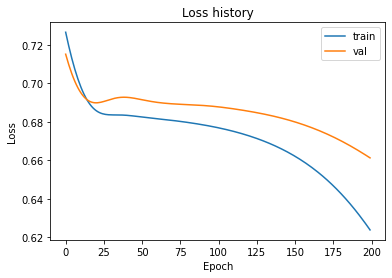

In [66]:
if __name__ == "__main__": 
    # Receiving user input
    classifier = input("It is time select your classifier! \
Type lr for logistic regression or nn for a simple neural network \
with one hidden layers containing 30 nodes: ")
    print(f'\n Your chosen classifier {classifier} will be fitted shortly')

    # dividing into separate datasets
    X_train, y_train, X_val, y_val, X_test, y_test = data_loader()
    _, n_features = X_train.shape

    # training the model
    train(200, classifier = classifier)

    test(n_features, classifier = classifier)